# GNSS interferometry with ATA

In this notebook we explore a GNSS interferometry recording done at Allen Telescope Array on 2020-10-04. The recording is only 15 seconds long and was done starting at 2020-10-04 13:56:56 UTC approximately with antennas 1h and 4g pointing to the Galileo satellite E31. The recording consists of complex baseband voltages for each antenna and polarization.

LO d from the RFCB was used on both antennas and was tuned to 1575.42 MHz.

Two USRP N32x were used to record IF signals at the LO output at 629 MHz with 30.72 Msps sample rate. The first USRP recorded both polarizations from antenna 1h (1hx, 1hy), and the second USRP recorded both polarizations from antenna 4g (4gx, 4gy). The USRPs were synchronized using an external 10 MHz reference and PPS coming from ATA installation. LO sharing was not enabled, so random phase offsets between the four channels are to be expected.

## Dask setup

We use Dask to perform FFTs in parallel and load the large IQ recording to RAM in chunks on demand.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
import dask.array as da
import dask.delayed
from dask.distributed import Client
import os

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'w'

client = Client(processes = False, threads_per_worker = 32,
                n_workers = 1, memory_limit = '64GB')
client

Client Scheduler: inproc://10.1.50.11/587845/1 Dashboard: http://10.1.50.11:8787/status,Cluster Workers: 1 Cores: 32 Memory: 64.00 GB


## Stations, baselines and triangles

Here we set up the list of stations, which correspond to each antenna and polarization and calculate the list of possible baselines to correlate and triangles to perform phase closures.

In [2]:
stations = ['1hx', '1hy', '4gx', '4gy']
baselines_idxs = [(j,k) for j in range(len(stations)) for k in range(j+1,len(stations))]
baselines_names = [f'{stations[j]}-{stations[k]}' for j,k in baselines_idxs]
triangles_idxs = [(j,k,l) for j in range(len(stations))
                      for k in range(j+1,len(stations))
                      for l in range(k+1,len(stations))]
triangles_names = [f'{stations[j]}->{stations[k]}->{stations[l]}' for j,k,l in triangles_idxs]

def find_baseline_sign(b):
    try:
        j = baselines_idxs.index(b)
    except ValueError:
        try:
            j = baselines_idxs.index(b[::-1])
        except ValueError:
            raise ValueError(f'Unable to find baseline {b}')
        else:
            return (j, -1)
    else:
        return (j, 1)

def triangle_baselines(t):
    return [tuple(np.roll(t, -j)[:2]) for j in range(3)]

triangles_baselines = [[find_baseline_sign(b) for b in triangle_baselines(t)]
                       for t in triangles_idxs]

## File loading

Here we lazily load the files with Dask.

In [3]:
def load_chunks(path, chunksize, dtype):
    fsize = os.stat(path).st_size
    dtype = np.dtype(dtype)
    items = fsize // dtype.itemsize
    chunks = [da.from_delayed(
                dask.delayed(np.fromfile)(path, dtype = dtype, count = chunksize, offset = j * dtype.itemsize),
                shape = (min(chunksize, items - j),),
                dtype = dtype)
             for j in range(0, items, chunksize)]
    return da.concatenate(chunks)

In [4]:
fs = 30.72e6
fLO = 1575.42e6
path = '/home/destevez/ATA_Galileo_E31_2ant_2pol/ATA_Galileo_E31_2ant_2pol'
x = da.stack([load_chunks(f'{path}_{chan}.sigmf-data', chunksize = 2**24, dtype = 'int16')
          for chan in stations])
x = (x[:,::2] + 1j * x[:,1::2])/2**15
x

dask.array<truediv, shape=(4, 459516552), dtype=complex128, chunksize=(1, 8388608), chunktype=numpy.ndarray>

## FX correlator

We perform the correlations in an FX correlator that uses a 4096 point FFT, giving channels of 7.5 kHz.

The delay between the antennas is small, on the order of 19 samples. Therefore, it can be corrected by multiplication by a suitable complex exponential in the frequency domain without incurring much correlation losses.

In [5]:
nfft = 4096
skyfreqs = np.fft.fftshift(np.fft.fftfreq(nfft, 1/fs)) + fLO
f = da.fft.fftshift(da.fft.fft(x[:,:x.shape[1]//nfft*nfft].reshape((x.shape[0], -1, nfft))), axes = 2)
f_pwr = f.real**2 + f.imag**2
fx = da.stack((f[j,...] * f[k,...].conj() for j,k in baselines_idxs ), axis = 0)
ifx = da.fft.ifft(fx)
ifx_pwr = ifx.real**2 + ifx.imag**2
ifx_argmax = da.argmax(ifx_pwr, axis = 2)

In [6]:
f_mean_pwr = f_pwr.mean(axis = 1).compute()

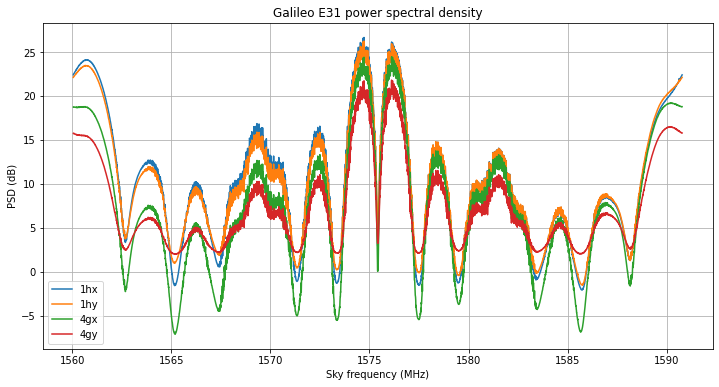

In [7]:
plt.plot(skyfreqs*1e-6, 10*np.log10(f_mean_pwr.T))
plt.grid()
plt.legend(stations)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('PSD (dB)')
plt.title('Galileo E31 power spectral density');

In [8]:
ifx_argmax_c = ifx_argmax.compute()

## Coarse baseline delay

For this short recording, the delay in integer samples corresponding to the 1h-4g baseline is always 19 samples. This simplifies the caculations. We correct by a delay of 19 samples by multiplying with a complex exponential in the frequency domain.

Then we can begin averaging across the frequency axis without incurring significant losses. We can use this averaging to estimate the baseline delay rate, correct for it, and then estimate the initial fractional delay (smaller than 0.5 samples) in the frequency domain and correct for it.

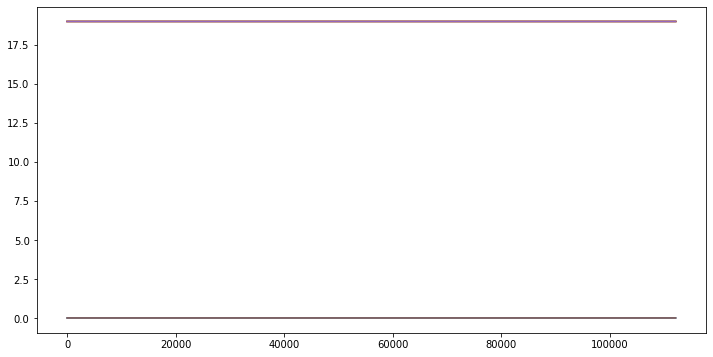

In [9]:
plt.plot(ifx_argmax_c.T);

In [10]:
delay_samples = np.average(ifx_argmax_c, axis = 1)
delay_samples

array([ 0., 19., 19., 19., 19.,  0.])

In [11]:
if not np.all(ifx_argmax_c == delay_samples.reshape((-1,1))):
    raise Exception('The delay in samples changes at some point')

In [12]:
delay_corr_f = np.exp(1j * 2 * np.pi * delay_samples[:,np.newaxis] * np.arange(nfft)[np.newaxis,:]/nfft)

## Baseline delay rate

We use a coherent averaging period of 0.1 seconds and also coherently average across the frequency axis. With this, we obtain the phase rate over time, and estimate the baseline delay rate from that.

In [13]:
Tavg = 0.1
avg = int(Tavg*fs/nfft)

In [14]:
fx_avg = fx[:,:fx.shape[1]//avg*avg,:].reshape((fx.shape[0],-1,avg,fx.shape[2])).mean(axis = 2)
fx_avg_corr = fx_avg.compute() * delay_corr_f[:,np.newaxis,:]

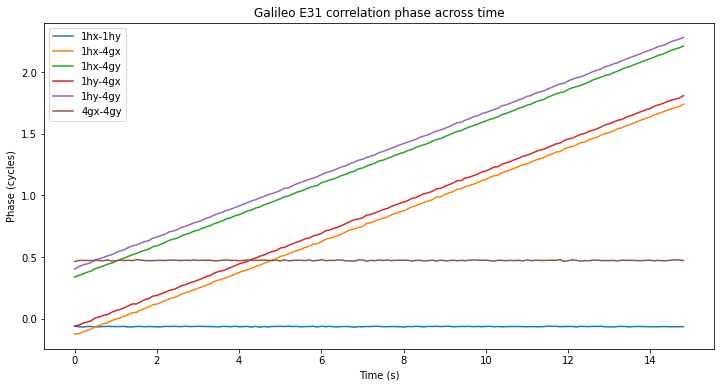

In [15]:
phase = np.unwrap(np.angle(np.average(fx_avg_corr, axis = 2)))
t_phase = np.arange(phase.shape[1]) * nfft*avg/fs
polys = np.empty((phase.shape[0], 2))
for j in range(phase.shape[0]):
    polys[j,:] = np.polyfit(t_phase, phase[j], 1)
plt.plot(t_phase, phase.T/(2*np.pi))
plt.xlabel('Time (s)')
plt.ylabel('Phase (cycles)')
plt.title('Galileo E31 correlation phase across time')
plt.legend(baselines_names);

In [16]:
polys[:,0]/(2*np.pi)

array([-9.61226339e-06,  1.26373753e-01,  1.26376721e-01,  1.26413119e-01,
        1.26418767e-01, -1.48144972e-05])

There is a single baseline rate, the one for 1h-4g. We estimate it as the average of the phase rates for the 4 baselines involving this pair of antennas. The other 2 baselines are zero baselines and have no drift.

In [17]:
baseline_rates = np.concatenate(([0], np.repeat(np.average(polys[1:5,0])/(2*np.pi), 4), [0]))
baseline_rates

array([0.        , 0.12639559, 0.12639559, 0.12639559, 0.12639559,
       0.        ])

The baseline rate correction is done differently on each frequency bin according to its corresponding sky frequency.

In [18]:
freq_proportion = skyfreqs / fLO
delay_rate_corr_f = np.exp(-1j * 2 * np.pi * baseline_rates[:,np.newaxis,np.newaxis] *
                           freq_proportion[np.newaxis,np.newaxis:] *
                           np.arange(fx_avg_corr.shape[1])[np.newaxis,:,np.newaxis] * nfft*avg/fs)
fx_avg_corr_rate = delay_rate_corr_f * fx_avg_corr

## Fractional delay estimation

With the baseline delay rate corrected, now we can average coherently over the time axis and estimate and correct the initial fractional delay (smaller than 0.5 samples) for the 1h-4g baseline by estimating the linear phase drift accross frequency.

In order to do so, we first subtract the average phase to each baseline correlation. This is just an intermediate step. A proper phase calibration of the visibilities will be done later, after the fractional delay has been corrected.

In [19]:
fx_fullavg = np.average(fx_avg_corr_rate, axis = 1)
phase_corr = np.angle(np.average(fx_fullavg, axis = 1))
phase_freq = np.angle(fx_fullavg * np.exp(-1j * phase_corr)[:,np.newaxis])
polys_phase_freq = np.empty((phase_freq.shape[0], 2))
for j in range(phase_freq.shape[0]):
    polys_phase_freq[j,:] = np.polyfit(skyfreqs, phase_freq[j], 1)

Here we show that correlation phase averages have been subtracted and the phase over frequency doesn't do a full cycle, which would mess with a linear fit.

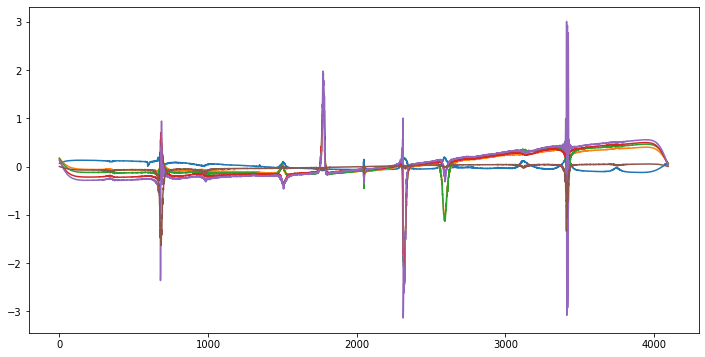

In [20]:
plt.plot(phase_freq.T);

There is a single baseline fractional delay, the one for 1h-4g. We estimate it as the average of the phase drift over frequency for the 4 baselines involving this pair of antennas. The other 2 baselines are zero baselines and have delay.

In [21]:
baseline_fractional_del = np.concatenate(([0], np.repeat(np.average(polys_phase_freq[1:5,0]), 4), [0]))
baseline_fractional_del

array([0.00000000e+00, 2.20132304e-08, 2.20132304e-08, 2.20132304e-08,
       2.20132304e-08, 0.00000000e+00])

In [22]:
fractional_delay_corr = baseline_fractional_del[:,np.newaxis] * (skyfreqs - fLO)[np.newaxis,:]

Here we show that our linear fit is able to correct the linear phase drift across frequency.

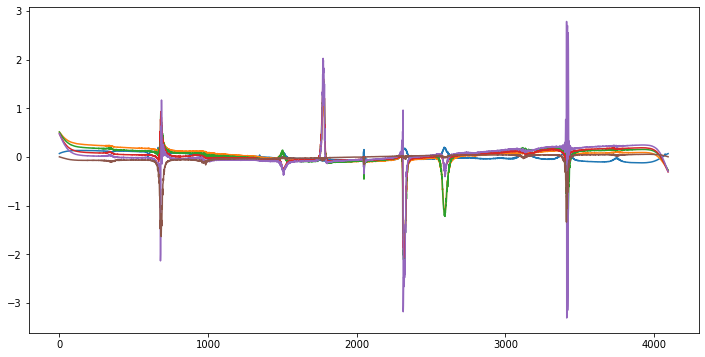

In [23]:
plt.plot((phase_freq-fractional_delay_corr).T);

## Uncalibrated visibilities

The uncalibrated visiblities over frequency are computed by applying the fractional delay correction we have just computed. By averaging over the frequency axis, we obtain the uncalibrated visibilities.

In [24]:
visib_uncal_f = fx_fullavg * np.exp(-1j*fractional_delay_corr)
visib_uncal = np.average(visib_uncal_f, axis = 1)
visib_uncal

array([ 36.20148477-15.33664783j,  20.12404135-20.66720182j,
       -11.45564765+17.17137249j,  25.96301136-10.23112945j,
       -16.93683177+10.48627842j, -15.73912059 +2.74800044j])

## Phase closures

We examine that the phase closures are close to 0, as expected for a point source target.

In [25]:
phase_closures = np.array([np.sum([np.angle(visib_uncal[j])*s for j,s in t]) for t in triangles_baselines])
print('Phase closures:')
for j,t in enumerate(triangles_names):
    print(f'{t}  {np.rad2deg(phase_closures[j]):.1f} deg')

Phase closures:
1hx->1hy->4gx  1.3 deg
1hx->1hy->4gy  1.6 deg
1hx->4gx->4gy  0.6 deg
1hy->4gx->4gy  0.4 deg


# Phase calibration

We perform phase calibration by choosing a reference station (1hx) and multiplying the complex voltages of each of the other stations by a suitable phasor so that the baselines involving the reference station are real and positive.

In [26]:
reference_station = 0
reference_baselines = [j for j,b in enumerate(baselines_idxs) if reference_station in b]
reference_baselines

[0, 1, 2]

In [27]:
second_station_ref_baselines = [list(set(baselines_idxs[b])-{reference_station})[0] for b in reference_baselines]
second_station_ref_baselines

[1, 2, 3]

In [28]:
ref_baselines_sign = np.array([1 if baselines_idxs[b][1] == s else -1
                          for b,s in zip(reference_baselines, second_station_ref_baselines)])
ref_baselines_sign

array([1, 1, 1])

In [29]:
phase_cal_station = np.zeros(len(stations))
phase_cal_station[second_station_ref_baselines] = ref_baselines_sign * np.angle(visib_uncal[reference_baselines])
phase_cal_station

array([ 0.        , -0.40072403, -0.79871299,  2.15912406])

In [30]:
phase_cal_baselines = np.array([phase_cal_station[j]-phase_cal_station[k] for j,k in baselines_idxs])
phase_cal_baselines

array([ 0.40072403,  0.79871299, -2.15912406,  0.39798897, -2.55984809,
       -2.95783705])

## Ampitude calibration

We perform amplitude calibration by assuming that each antenna and polarization should collect the same flux from the satellite signal. This is reasonable, because the dishes should have nearly the same performance and the GNSS signal is circularly polarized, so both polarizations should collect the same power.

We compute the average power collected by each station, and use that to derive amplitude calibrations that give normalized correlations (so that the maximum correlation would be 1).

In [31]:
station_pwr = np.average(f_mean_pwr, axis = 1)
station_pwr

array([41.91023448, 38.88206566, 22.54972175, 13.09923904])

In [32]:
amplitude_cal_station = 1/np.sqrt(station_pwr)
amplitude_cal_baselines = np.array([amplitude_cal_station[j]*amplitude_cal_station[k]
                                            for j,k in baselines_idxs])

## Calibrated visibilities

We apply the phase and amplitude calibrations to the visibilities over frequency and to the visibilities. We show that calibrated visibility amplitudes are close to 1 and calibrated visibility phases are close to 0, as expected for a point source.

In [33]:
visib_cal_f = visib_uncal_f * (np.exp(1j*phase_cal_baselines) * amplitude_cal_baselines)[:,np.newaxis]
visib_cal = visib_uncal * np.exp(1j*phase_cal_baselines) * amplitude_cal_baselines
visib_cal

array([0.97394932+0.00000000e+00j, 0.93833908+5.77829318e-17j,
       0.88098095+7.58136024e-17j, 0.94220167+2.13057759e-02j,
       0.88233897+2.41555866e-02j, 0.92956908+1.01337820e-02j])

In [34]:
print('Calibrated visibility amplitudes:')
for j,b in enumerate(baselines_names):
    print(f'{b}  {np.abs(visib_cal[j]):.3f}')

Calibrated visibility amplitudes:
1hx-1hy  0.974
1hx-4gx  0.938
1hx-4gy  0.881
1hy-4gx  0.942
1hy-4gy  0.883
4gx-4gy  0.930


In [35]:
print('Calibrated visibility phases:')
for j,b in enumerate(baselines_names):
    print(f'{b}  {np.rad2deg(np.angle(visib_cal[j])):.1f} deg')

Calibrated visibility phases:
1hx-1hy  0.0 deg
1hx-4gx  0.0 deg
1hx-4gy  0.0 deg
1hy-4gx  1.3 deg
1hy-4gy  1.6 deg
4gx-4gy  0.6 deg


## Calibrations

Here we summarized the calibrations that we have applied to the data.

In [36]:
print('Calibrations')
print('='*20)
print()
print('Fringe stopping')
print('-'*20)
print('* Baseline 1h-4g')
print(f'  Delay rate {-baseline_rates[1]/fLO*scipy.constants.c:.6f} m/s')
print(f'  Initial delay {(delay_samples[1]/fs - baseline_fractional_del[1]/(2*np.pi))*scipy.constants.c:.3f} m')
print()
print('(baseline delay for A0-A1 is defined as arrival time at A0 - arrival time at A1)')
print()
print('Station phase corrections:')
print('-'*40)
for p,s in zip(phase_cal_station,stations):
    print(f'{s}  {np.rad2deg(p):.1f} deg')
print()
print('Station amplitude corrections:')
print('-'*40)
for a,s in zip(amplitude_cal_station,stations):
    print(f'{s}  {20*np.log10(a):.1f} dB')

Calibrations

Fringe stopping
--------------------
* Baseline 1h-4g
  Delay rate -0.024052 m/s
  Initial delay 184.368 m

(baseline delay for A0-A1 is defined as arrival time at A0 - arrival time at A1)

Station phase corrections:
----------------------------------------
1hx  0.0 deg
1hy  -23.0 deg
4gx  -45.8 deg
4gy  123.7 deg

Station amplitude corrections:
----------------------------------------
1hx  -16.2 dB
1hy  -15.9 dB
4gx  -13.5 dB
4gy  -11.2 dB


## Visibilities across frequency

By examining the visibilities across frequency, we can see frequency dependent effects on the receiver chain in each of the channels.

The calibrated visbility phase shows frequency-dependent phase delays in the receiver chain.

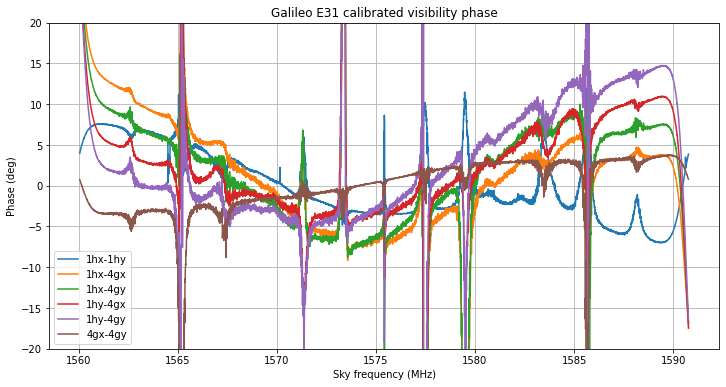

In [37]:
plt.plot(skyfreqs*1e-6, np.rad2deg(np.angle(visib_cal_f)).T)
plt.ylim((-20,20))
plt.grid()
plt.legend(baselines_names)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Phase (deg)')
plt.title('Galileo E31 calibrated visibility phase');

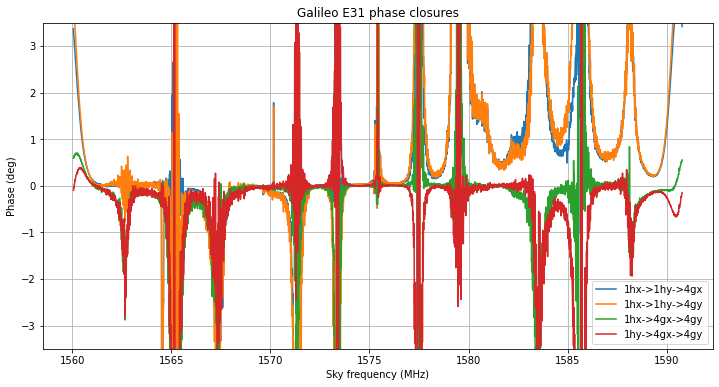

In [38]:
phase_closures_f = np.array([np.sum([np.angle(visib_cal_f[j])*s for j,s in t], axis = 0) for t in triangles_baselines])
plt.plot(skyfreqs*1e-6, np.rad2deg(phase_closures_f).T)
plt.ylim((-3.5,3.5))
plt.grid()
plt.legend(triangles_names)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Phase (deg)')
plt.title('Galileo E31 phase closures');

The calibrated visibility amplitudes show basically the PSD of the GNSS signal, and are not very useful to study the receiver chain.

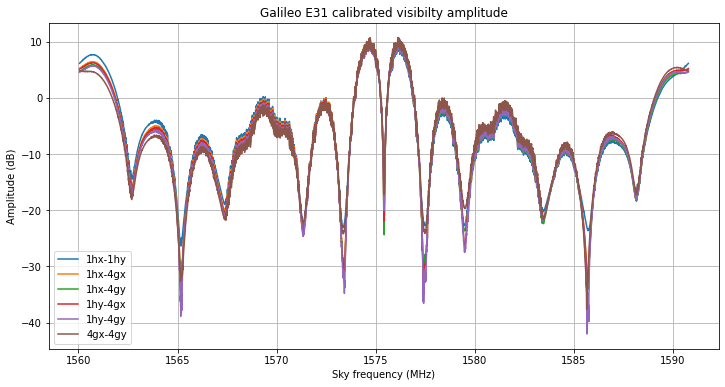

In [39]:
plt.plot(skyfreqs*1e-6, 10*np.log10(np.abs(visib_cal_f)).T)
plt.grid()
plt.legend(baselines_names)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Amplitude (dB)')
plt.title('Galileo E31 calibrated visibilty amplitude');

Weigthing the uncalibrated visibility amplitudes using the inverse PSD of the signal is equivalent to performing a separate amplitude calibration by frequency, which calibrates out the fact that the source is not spectrally flat.

Thus, we get an amplitude smaller than one that indicates the correlation losses for that baseline.

It is remarkable that baselines involving 4gy have worse losses than the others. The reason is that 4gy has much less SNR than the other stations. This can be seen in the PSD, by noting that the signal nulls are not so deep as for the other channels.

In the same way, the weaker sidelobes have noticeable correlation losses (amplitude around 0.9) for all baselines.

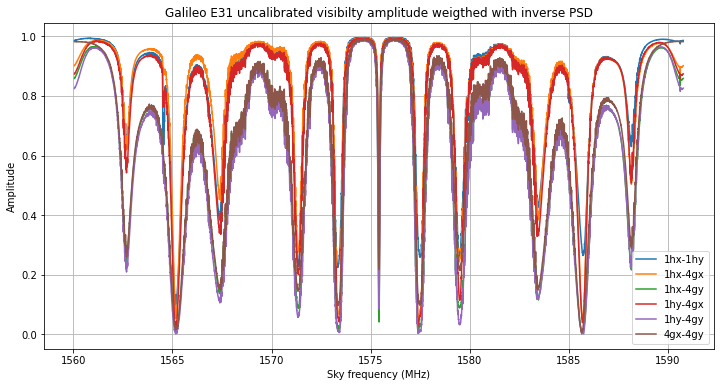

In [40]:
amplitude_cal_f_baselines = np.array([1/np.sqrt(f_mean_pwr[j,:]*f_mean_pwr[k,:])
                                            for j,k in baselines_idxs])
plt.plot(skyfreqs*1e-6, np.abs(visib_uncal_f * amplitude_cal_f_baselines).T)
plt.grid()
plt.legend(baselines_names)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('Galileo E31 uncalibrated visibilty amplitude weigthed with inverse PSD');

To study the frequency dependent amplitude behaviour of the receiver chain we first compute the calibrated PSD for each channel, using the amplitude calibration. Here we can see that channel 4gx has the best SNR (it has the deepest nulls), so we will use that as a reference for the source PSD.

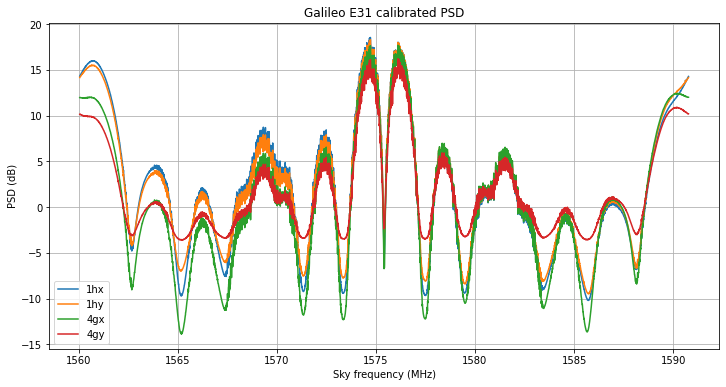

In [41]:
plt.plot(skyfreqs*1e-6, 10*np.log10(f_mean_pwr * amplitude_cal_station[:,np.newaxis]).T)
plt.grid()
plt.legend(stations)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('PSD (dB)')
plt.title('Galileo E31 calibrated PSD');

If we weight the PSD of each channel with the inverse of the PSD for channel 4gx, we see that the channels for antenna 1h have a noticeable slope over frequency.

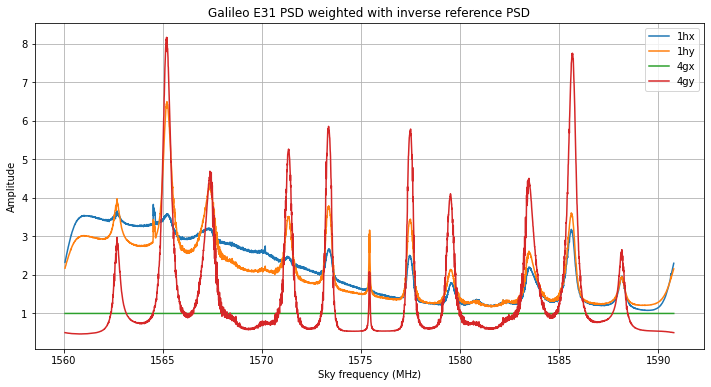

In [42]:
ref_psd_station = 2
ref_psd = f_mean_pwr[ref_psd_station,:]
plt.plot(skyfreqs*1e-6, (f_mean_pwr / ref_psd[np.newaxis,:]).T)
plt.grid()
plt.legend(stations)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('Galileo E31 PSD weighted with inverse reference PSD');

Next, we can plot the calibrated visibility amplitudes, weigthed with the inverse of the reference PSD to correct for the source non-flat PSD. Here the slope caused by 1hx and 1hy is clearly visible.

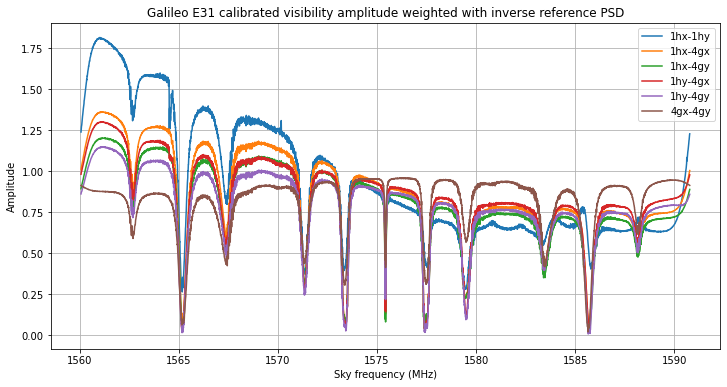

In [43]:
z = visib_cal_f.T / ref_psd[:,np.newaxis] / amplitude_cal_station[ref_psd_station]**2
plt.plot(skyfreqs*1e-6, np.abs(z))
plt.grid()
plt.legend(baselines_names)
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('Galileo E31 calibrated visibility amplitude weighted with inverse reference PSD');

## Goodness of baseline delay rate estimation

To check the goodness of the baseline delay rate estimation, we go back to the correlations over time and apply all the calibrations to obtain calibrated visibilities over time.

In [44]:
visib_cal_t = fx_avg_corr_rate * np.exp(-1j*fractional_delay_corr)[:,np.newaxis,:] \
        * (np.exp(1j*phase_cal_baselines) * amplitude_cal_baselines)[:,np.newaxis,np.newaxis]
visib_cal_t = np.average(visib_cal_t, axis = 2)

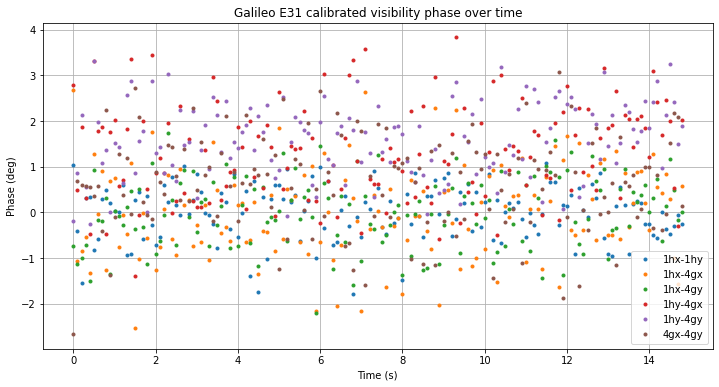

In [45]:
plt.plot(t_phase, np.rad2deg(np.angle(visib_cal_t.T)), '.')
plt.grid()
plt.legend(baselines_names)
plt.xlabel('Time (s)')
plt.ylabel('Phase (deg)')
plt.title('Galileo E31 calibrated visibility phase over time');

We observe no significant drift in any of the calibrated visibilities. The standard deviations of the visibility phases over time are on the order of 1 degree.

In [46]:
np.std(np.rad2deg(np.angle(visib_cal_t)), axis = 1)

array([0.58713514, 0.98566482, 0.7624525 , 1.03636385, 0.80275483,
       1.0196561 ])

Even though we don't have many measurements for phase over time, their distributions do not show any significant bias from being normally distributed.

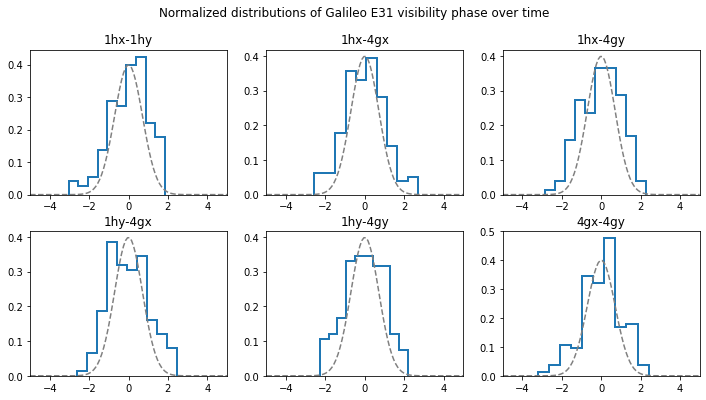

In [47]:
fig, axs = plt.subplots(2, len(baselines_idxs)//2)
tau = np.linspace(-5,5,100)
N = np.exp(-tau**2)/np.sqrt(2*np.pi)
for j,ax in enumerate(axs.ravel()):
    y = np.angle(visib_cal_t[j])
    y = y - np.average(y)
    y = y / np.std(y)
    ax.plot(tau, N, '--', color = 'grey')
    ax.hist(y, bins = 10, histtype = 'step', density = True, linewidth = 2, color = 'C0')
    ax.set_xlim((-5,5))
    ax.set_title(baselines_names[j])
plt.suptitle('Normalized distributions of Galileo E31 visibility phase over time')
plt.subplots_adjust(hspace = 0.25);

With a variance of $\sigma = 1\ \textrm{deg}^2$, we have a variance of $\sigma^2/\sum{(t_j - \overline{t_j})^2}$ for the baseline drift rate obtained by linear regression. This works out to about 10um/s of standard deviation.

In [48]:
np.deg2rad(1)/(2*np.pi)/np.sqrt(np.sum((t_phase-np.average(t_phase))**2))/fLO*scipy.constants.c

1.0067991708299599e-05

We have estimated the delay drift from measurements of 4 baselines. The standard deviation of these 4 measurements is actually on the order of 4um/s.

In [49]:
np.std(polys[1:5,0])/(2*np.pi)/fLO*scipy.constants.c

3.8967315479389814e-06

## Comparison with simulated calculation

Theoretical delay rate for 1h-4g baseline using broadcast ephemerides, timestamp 2020-10-04 13:57:04 UTC (13:57:22 GST), which is the mipoint of the recording.

Note that the precise timestamp of the recording is not know; the timestamp comes from `stat` modify time.

We use WGS84 positions for the antennas:
* 1h: 40.816410ºN 121.471828ºW 1000m geoid height
* 4g: 40.818316ºN 121.470420ºW 1000m geoid height

These come from Google maps satellite view, so they are not very precise.

In [50]:
simulation_delay_rate = -0.024042621

In [51]:
measured_delay_rate = -baseline_rates[1]/fLO*scipy.constants.c
measured_delay_rate

-0.02405228100532019

The error between simulation and measurements (in m/s) is:

In [52]:
measured_delay_rate-simulation_delay_rate

-9.660005320190346e-06

This is completely within our 10um/s error budget.

## Visibilitiy amplitudes over time

The following plot shows the evolution of calibrated visibility amplitudes over time.

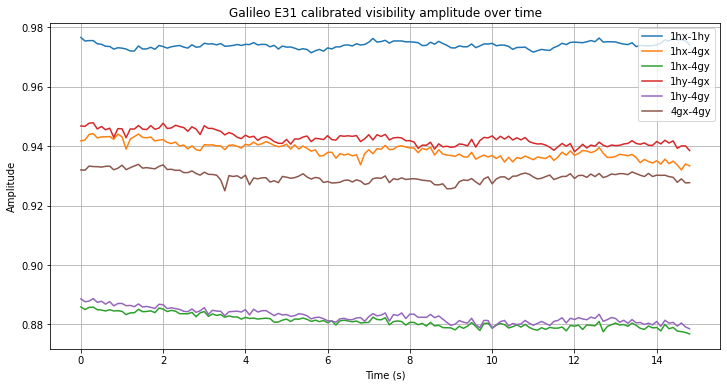

In [53]:
plt.plot(t_phase, np.abs(visib_cal_t.T))
plt.grid()
plt.legend(baselines_names)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Galileo E31 calibrated visibility amplitude over time');